In [1]:
import ira
%alphalab dark

%run initlibs.py Lustre dark
from tools.loaders.data_loaders import load_data, load_instrument_data, ls_symbols
from tools.charting.signals_charts import plot_entries

import qlearn as q
from sklearn.base import BaseEstimator
import seaborn as sns

%run trackers.py
%run generators.py
%run indicators.py

Reloaded /usr/local/envs/ira_p36/lib/python3.6/site-packages/ira/experimental/c_simulator_core.pyx


# Breakout system

<hr/>
To test RAD chandelier exits we will run it against trading signals generated by classical breakout strategy based that should demonstrate good results on trending markets.

This strategy based on weekly timeframe but we would like to see if it can work on daily/intraday as well.

For entering long trades we use following rule:

   > <font color='orange'>C > (Ref(C,-1) + .75 * ATR(15) and C > Mov(C,150,E) and V >= Mov(V,10,W))</font>

And for shorts:

   > <font color='orange'>C < (Ref(C,-1) - .75 * ATR(15) and C < Mov(C,150,E) and V >= Mov(V,10,W))</font>
   
Where:
   - C, V: close price and Volumes for current bar
   - Ref(C, -1): close price on previous bar
   - ATR(15): 15 period Average True Range on current bar
   - Mov(C,n,E): exponential moving average (on closes)
   - Mov(V,n,W): weighted moving average (on volumes)

(Note above is only for initial entry , not the pyramid entries). If were in long trades we don't open a short and vica versa.

So in this study we are going to test if RAD chandelier trailig exit may improve results of momentum strategy.

<hr/>

In [2]:
md = load_data('amp:AUS200', 'amp:SPXM', 'amp:XTIUSD')

First we find out average bid/ask spreads (as because we do not have tick data but we want to take in account slippages). Probably it will not play significant role on daily entries but it always worth to be taken in account.

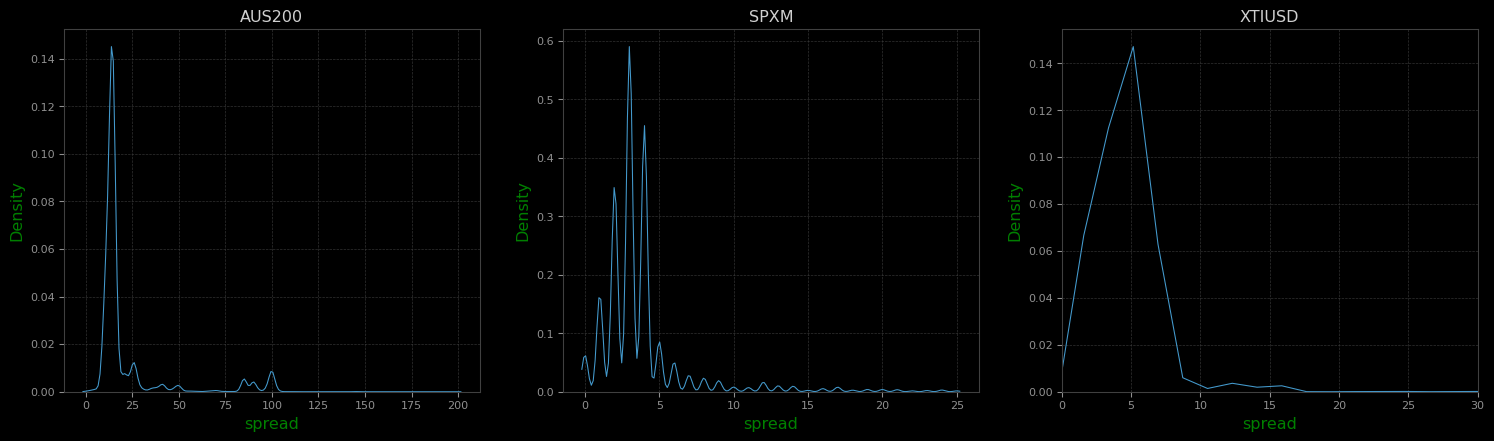

In [3]:
fig(19, 5)
sbp(13,1); sns.kdeplot(md.ticks()['AUS200'].spread, cut=1); plt.title('AUS200')
sbp(13,2); sns.kdeplot(md.ticks()['SPXM'].spread, cut=1); plt.title('SPXM')
sbp(13,3); sns.kdeplot(md.ticks()['XTIUSD'].spread, cut=1); plt.title('XTIUSD'); plt.xlim(0,30);

So we can use 15 ticks for AUS, 5 for SPXM and 5 for XTI

In [3]:
spreads = {
   'AUS200': 15*0.1,
   'SPXM': 5*0.1,
   'XTIUSD': 5*0.01,
}

# Basic model tests

In [44]:
data = md.ohlc('1h')

In [46]:
lbr = q.SingleInstrumentComposer(Lustre('1d', 14, 0.75, 150, 10)).fit(md.ticks())

In [ ]:
epf = lbr.estimated_portfolio(md.ticks(), q.ReverseSignalsSharpeScoring(commissions=100*0.25))
plt.plot(epf.fillna(0).cumsum())

Now we will run this model fro AUS200 index using different setups for RAD stops: 
   - here we could variate days in ATR period (let's say 12, 22)
   - and ATR stop multiplier (3,4,5)

Now we will run this model for AUS200, SPXM and XTIUSD CFD's on existing data (daily timeframe). 
Here for comparison we also run signals with no any tracking logic (<font color='red'>FixedTracker</font>) that wouldn't do any risk manegement job but only opens position and waits for opposite signal (reversive trading)

Here we use following info from AMP futures:
   - AUS200: tick size = 0.1, contract size = 1, tick_price = \\$0.1
   - SPXm: tick size = 0.1, contract size = 10, tick_price = \\$1
   - XTIUSD: tick size = 0.01, contract size = 100, tick_price = \\$1

<font color='green'>AUS200 simulations</font>
<hr/>

In [ ]:
r_aus = q.simulation({
    'Basic / no RM (aus200)': [lbr, q.FixedTrader(1, 0, 0)], 
    'Basic / RAD(daily, 12 x 3)': [lbr, RADChandelier(1, '1d', 12, 3)], 
    'Basic / RAD(daily, 22 x 3)': [lbr, RADChandelier(1, '1d', 22, 3)], 
    'Basic / RAD(daily, 12 x 4)': [lbr, RADChandelier(1, '1d', 12, 4)], 
    'Basic / RAD(daily, 22 x 4)': [lbr, RADChandelier(1, '1d', 22, 4)], 
    'Basic / RAD(daily, 12 x 5)': [lbr, RADChandelier(1, '1d', 12, 5)], 
    'Basic / RAD(daily, 22 x 5)': [lbr, RADChandelier(1, '1d', 22, 5)], 
}, md['AUS200'].ohlcs('1h'), 'stock', 'Lustre AUS200 1D', spreads=spreads)

<font color='green'>SPXM simulations</font>
<hr/>

In [ ]:
r_spx = q.simulation({
    'Basic / no RM (spx)': [lbr, q.FixedTrader(10, 0, 0)], 
    'Basic / RAD(daily, 12 x 3) (spx)': [lbr, RADChandelier(10, '1d', 12, 3)], 
    'Basic / RAD(daily, 22 x 3) (spx)': [lbr, RADChandelier(10, '1d', 22, 3)], 
    'Basic / RAD(daily, 12 x 4) (spx)': [lbr, RADChandelier(10, '1d', 12, 4)], 
    'Basic / RAD(daily, 22 x 4) (spx)': [lbr, RADChandelier(10, '1d', 22, 4)], 
    'Basic / RAD(daily, 12 x 5) (spx)': [lbr, RADChandelier(10, '1d', 12, 5)], 
    'Basic / RAD(daily, 22 x 5) (spx)': [lbr, RADChandelier(10, '1d', 22, 5)], 
}, md['SPXM'].ohlcs('1h'), 'stock', 'Lustre SPXM 1D', spreads=spreads)

<font color='green'>XTI simulations</font>
<hr/>

In [ ]:
r_xti = q.simulation({
    'Basic / no RM (xti)': [lbr, q.FixedTrader(100, 0, 0)], 
    'Basic / RAD(daily, 12 x 3) (xti)': [lbr, RADChandelier(100, '1d', 12, 3)], 
    'Basic / RAD(daily, 22 x 3) (xti)': [lbr, RADChandelier(100, '1d', 22, 3)], 
    'Basic / RAD(daily, 12 x 4) (xti)': [lbr, RADChandelier(100, '1d', 12, 4)], 
    'Basic / RAD(daily, 22 x 4) (xti)': [lbr, RADChandelier(100, '1d', 22, 4)], 
    'Basic / RAD(daily, 12 x 5) (xti)': [lbr, RADChandelier(100, '1d', 12, 5)], 
    'Basic / RAD(daily, 22 x 5) (xti)': [lbr, RADChandelier(100, '1d', 22, 5)], 
}, md['XTIUSD'].ohlcs('1h'), 'stock', 'Lustre XTI 1D', spreads=spreads)

Following is simulation results for every symbol
<hr/>

 0: Lustre AUS200 1D/Basic / no RM (aus200)      : Sharpe: -inf | Sortino: -0.19 | CAGR: -39.46 | DD: $2729.50 (89.30%) | Gain: $295.80 | Execs: 15[OK]
 1: Lustre AUS200 1D/Basic / RAD(daily, 12 x 3)  : Sharpe: 0.16 | Sortino: 0.24 | CAGR: -4.34 | DD: $2364.20 (73.05%) | Gain: $-120.90 | Execs: 31[OK]
 2: Lustre AUS200 1D/Basic / RAD(daily, 22 x 3)  : Sharpe: 0.26 | Sortino: 0.42 | CAGR: 1.93 | DD: $1488.00 (60.14%) | Gain: $57.00 | Execs: 23[OK]
 3: Lustre AUS200 1D/Basic / RAD(daily, 12 x 4)  : Sharpe: 0.47 | Sortino: 0.74 | CAGR: 11.47 | DD: $1900.60 (61.18%) | Gain: $370.90 | Execs: 29[OK]
 4: Lustre AUS200 1D/Basic / RAD(daily, 22 x 4)  : Sharpe: 0.54 | Sortino: 0.82 | CAGR: 15.62 | DD: $2140.30 (67.69%) | Gain: $524.20 | Execs: 19[OK]
 5: Lustre AUS200 1D/Basic / RAD(daily, 12 x 5)  : Sharpe: 0.68 | Sortino: 1.11 | CAGR: 25.56 | DD: $1312.80 (46.23%) | Gain: $936.90 | Execs: 11[OK]
 6: Lustre AUS200 1D/Basic / RAD(daily, 22 x 5)  : Sharpe: 0.79 | Sortino: 1.21 | CAGR: 33.56 | DD:

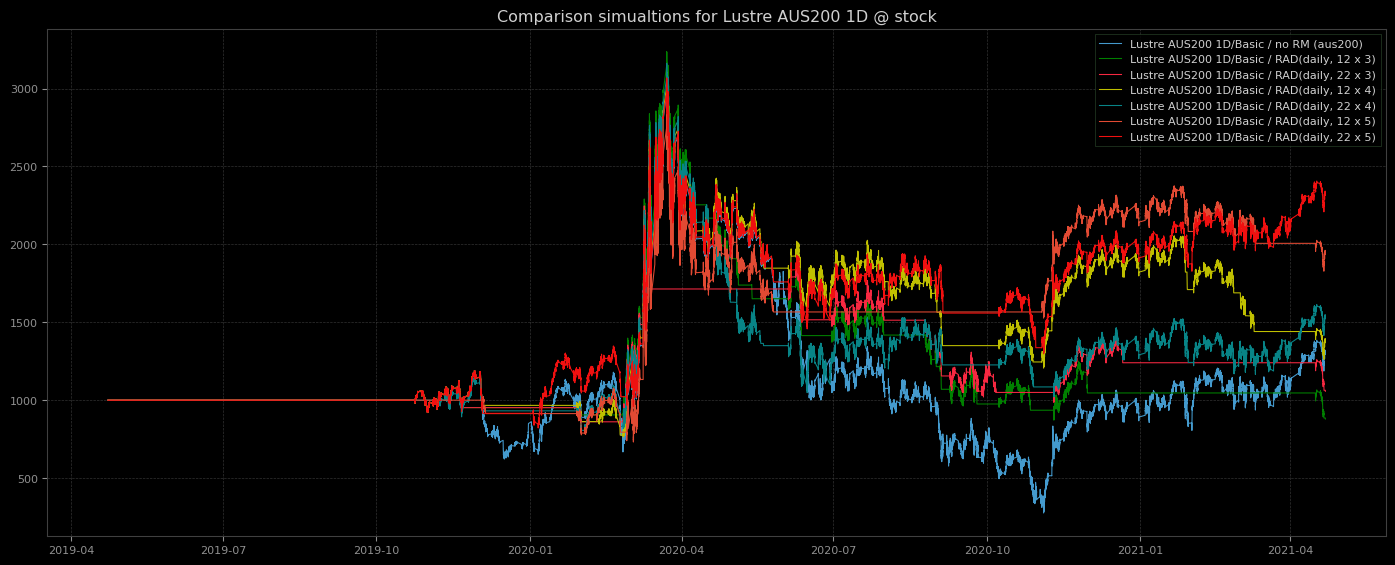

In [9]:
fig(18, 7)
res_aux = r_aus.report(1000, commissions=100*2.5)

 0: Lustre SPXM 1D/Basic / no RM (spx)               : Sharpe: 1.32 | Sortino: 2.19 | CAGR: 147.03 | DD: $9606.00 (87.42%) | Gain: $12880.00 | Execs: 5[OK]
 1: Lustre SPXM 1D/Basic / RAD(daily, 12 x 3) (spx)  : Sharpe: 1.12 | Sortino: 2.24 | CAGR: 107.00 | DD: $6129.00 (66.53%) | Gain: $7300.00 | Execs: 27[OK]
 2: Lustre SPXM 1D/Basic / RAD(daily, 22 x 3) (spx)  : Sharpe: -inf | Sortino: 0.81 | CAGR: -53.08 | DD: $3522.00 (91.91%) | Gain: $5326.00 | Execs: 23[OK]
 3: Lustre SPXM 1D/Basic / RAD(daily, 12 x 4) (spx)  : Sharpe: 1.19 | Sortino: 2.20 | CAGR: 117.21 | DD: $7220.00 (67.90%) | Gain: $8547.00 | Execs: 29[OK]
 4: Lustre SPXM 1D/Basic / RAD(daily, 22 x 4) (spx)  : Sharpe: -inf | Sortino: -0.01 | CAGR: -63.72 | DD: $1607.00 (84.94%) | Gain: $8444.00 | Execs: 23[OK]
 5: Lustre SPXM 1D/Basic / RAD(daily, 12 x 5) (spx)  : Sharpe: -inf | Sortino: -1.33 | CAGR: -67.24 | DD: $696.00 (69.05%) | Gain: $6029.00 | Execs: 23[OK]
 6: Lustre SPXM 1D/Basic / RAD(daily, 22 x 5) (spx)  : Sharpe: 

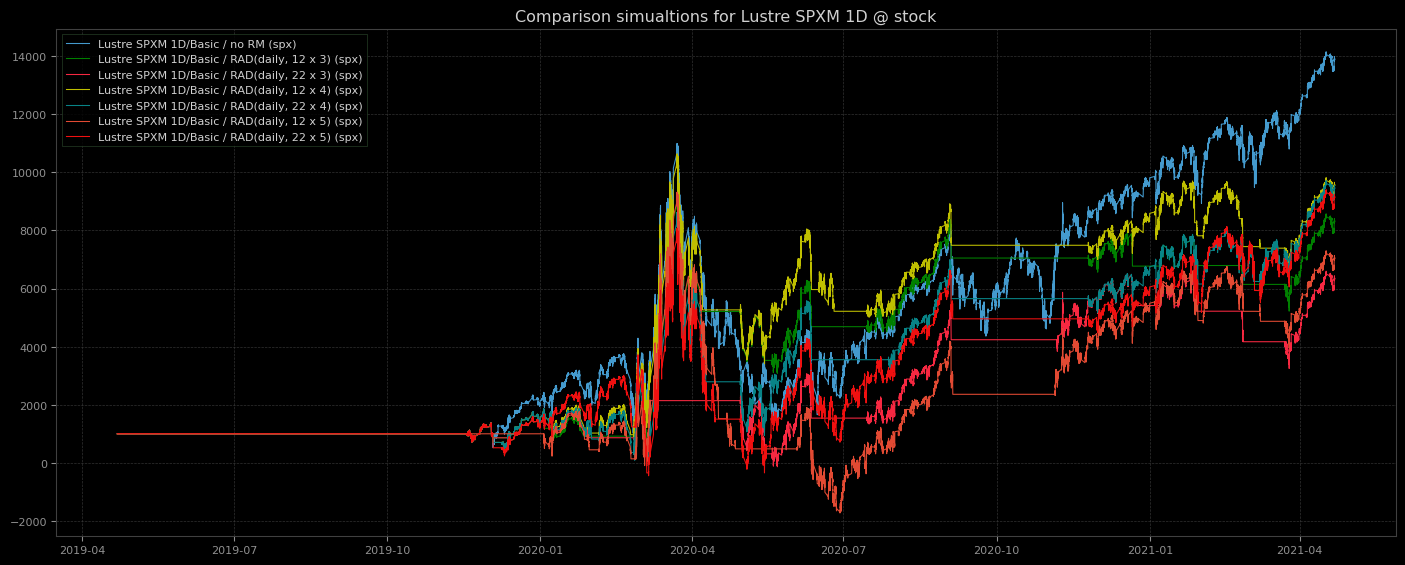

In [10]:
fig(18, 7)
res_spx = r_spx.report(1000, commissions=100*2.5)

 0: Lustre XTI 1D/Basic / no RM (xti)               : Sharpe: -inf | Sortino: -1.44 | CAGR: -71.13 | DD: $777.00 (70.51%) | Gain: $2930.00 | Execs: 10[OK]
 1: Lustre XTI 1D/Basic / RAD(daily, 12 x 3) (xti)  : Sharpe: 1.06 | Sortino: 1.72 | CAGR: 55.72 | DD: $2020.00 (46.69%) | Gain: $2710.00 | Execs: 25[OK]
 2: Lustre XTI 1D/Basic / RAD(daily, 22 x 3) (xti)  : Sharpe: 0.83 | Sortino: 1.44 | CAGR: 45.46 | DD: $1551.00 (45.00%) | Gain: $2032.00 | Execs: 27[OK]
 3: Lustre XTI 1D/Basic / RAD(daily, 12 x 4) (xti)  : Sharpe: -inf | Sortino: -1.17 | CAGR: -66.04 | DD: $778.00 (70.60%) | Gain: $1956.00 | Execs: 23[OK]
 4: Lustre XTI 1D/Basic / RAD(daily, 22 x 4) (xti)  : Sharpe: 1.28 | Sortino: 2.07 | CAGR: 77.70 | DD: $1812.00 (31.74%) | Gain: $4485.00 | Execs: 17[OK]
 5: Lustre XTI 1D/Basic / RAD(daily, 12 x 5) (xti)  : Sharpe: 0.93 | Sortino: 1.45 | CAGR: 44.44 | DD: $3012.00 (55.51%) | Gain: $1970.00 | Execs: 13[OK]
 6: Lustre XTI 1D/Basic / RAD(daily, 22 x 5) (xti)  : Sharpe: -inf | Sorti

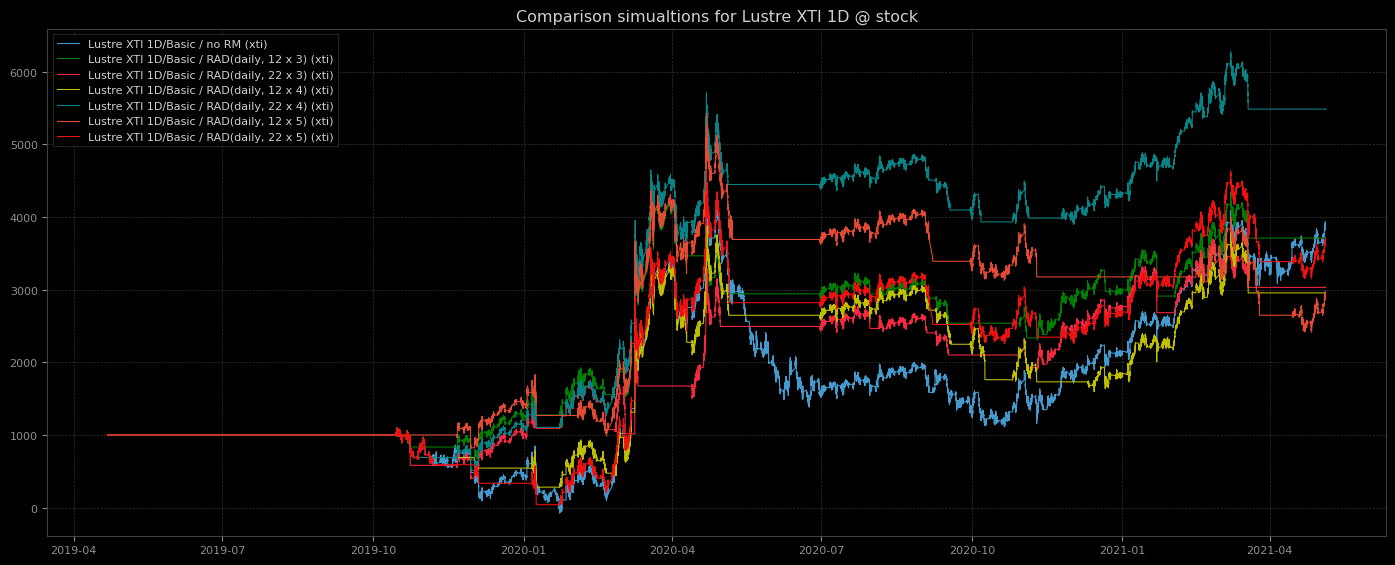

In [11]:
fig(18, 7)
res_xti = r_xti.report(1000, commissions=100*2.5)

<font size=3>Results </font>
<hr/>

In [52]:
res_aux.sort_values('sharpe', ascending=False)

,Name,sharpe,sortino,cagr,dd,dd_pct,gain,number_executions
6,"Lustre AUS200 1D/Basic / RAD(daily, 22 x 5)",0.786178,1.214042,33.555733,1769.9,57.700333,1317.5,11
5,"Lustre AUS200 1D/Basic / RAD(daily, 12 x 5)",0.679928,1.107440,25.556784,1312.8,46.231864,936.9,11
4,"Lustre AUS200 1D/Basic / RAD(daily, 22 x 4)",0.539888,0.821671,15.615069,2140.3,67.692454,524.2,19
3,"Lustre AUS200 1D/Basic / RAD(daily, 12 x 4)",0.468060,0.737292,11.472033,1900.6,61.181394,370.9,29
2,"Lustre AUS200 1D/Basic / RAD(daily, 22 x 3)",0.261320,0.416854,1.926734,1488.0,60.140652,57.0,23
1,"Lustre AUS200 1D/Basic / RAD(daily, 12 x 3)",0.155272,0.237692,-4.339094,2364.2,73.054817,-120.9,31
0,Lustre AUS200 1D/Basic / no RM (aus200),-inf,-0.191943,-39.458222,2729.5,89.295646,295.8,15


In [53]:
res_spx.sort_values('sharpe', ascending=False)

,Name,sharpe,sortino,cagr,dd,dd_pct,gain,number_executions
0,Lustre SPXM 1D/Basic / no RM (spx),1.324404,2.193056,147.027374,9606.0,87.422643,12880.0,5
3,"Lustre SPXM 1D/Basic / RAD(daily, 12 x 4) (spx)",1.189727,2.200152,117.205606,7220.0,67.895430,8547.0,29
1,"Lustre SPXM 1D/Basic / RAD(daily, 12 x 3) (spx)",1.122446,2.238096,107.000921,6129.0,66.532783,7300.0,27
2,"Lustre SPXM 1D/Basic / RAD(daily, 22 x 3) (spx)",-inf,0.806697,-53.081794,3522.0,91.910230,5326.0,23
4,"Lustre SPXM 1D/Basic / RAD(daily, 22 x 4) (spx)",-inf,-0.009871,-63.718738,1607.0,84.936575,8444.0,23
5,"Lustre SPXM 1D/Basic / RAD(daily, 12 x 5) (spx)",-inf,-1.331073,-67.242434,696.0,69.047619,6029.0,23
6,"Lustre SPXM 1D/Basic / RAD(daily, 22 x 5) (spx)",-inf,-1.487130,-72.948008,1079.0,78.415698,8132.0,17


In [54]:
res_xti.sort_values('sharpe', ascending=False)

,Name,sharpe,sortino,cagr,dd,dd_pct,gain,number_executions
4,"Lustre XTI 1D/Basic / RAD(daily, 22 x 4) (xti)",1.282295,2.072494,77.703121,1812.0,31.744919,4485.0,17
1,"Lustre XTI 1D/Basic / RAD(daily, 12 x 3) (xti)",1.059003,1.722781,55.716783,2020.0,46.694406,2710.0,25
5,"Lustre XTI 1D/Basic / RAD(daily, 12 x 5) (xti)",0.926071,1.454374,44.443462,3012.0,55.510505,1970.0,13
2,"Lustre XTI 1D/Basic / RAD(daily, 22 x 3) (xti)",0.830586,1.443155,45.455081,1551.0,44.995648,2032.0,27
0,Lustre XTI 1D/Basic / no RM (xti),-inf,-1.437743,-71.126285,777.0,70.508167,2930.0,10
3,"Lustre XTI 1D/Basic / RAD(daily, 12 x 4) (xti)",-inf,-1.171496,-66.036181,778.0,70.598911,1956.0,23
6,"Lustre XTI 1D/Basic / RAD(daily, 22 x 5) (xti)",-inf,-1.812432,-66.416452,779.0,70.689655,2707.0,17


We can see that only applying RAD exits (no pyramiding) led to some improvements (excepting SPXM - here simple reversive model gave most profitable results).

Also main concern here is small number of signals

In [55]:
r_aus.results[4].executions

,instrument,quantity,exec_price,comment
2019-11-07 23:59:59,AUS200,1.0,6742.45,
2019-12-03 08:48:00,AUS200,-1.0,6672.95,stop long at 6674.45
2020-01-28 23:59:59,AUS200,1.0,7033.85,
2020-02-24 08:48:00,AUS200,-1.0,6907.45,stop long at 6908.95
2020-02-25 23:59:59,AUS200,-1.0,6744.75,
2020-04-30 03:48:00,AUS200,1.0,5529.05,stop short at 5527.55
2020-05-01 23:59:59,AUS200,-1.0,5238.25,
2020-05-18 08:48:00,AUS200,1.0,5506.75,stop short at 5505.25
2020-05-19 23:59:59,AUS200,-1.0,5491.35,
2020-05-20 00:48:00,AUS200,1.0,5527.85,stop short at 5526.35


Let's see how these signals were performed on charts

<font color='green' size=2>Best model signals for AUS200</font>
<hr/>

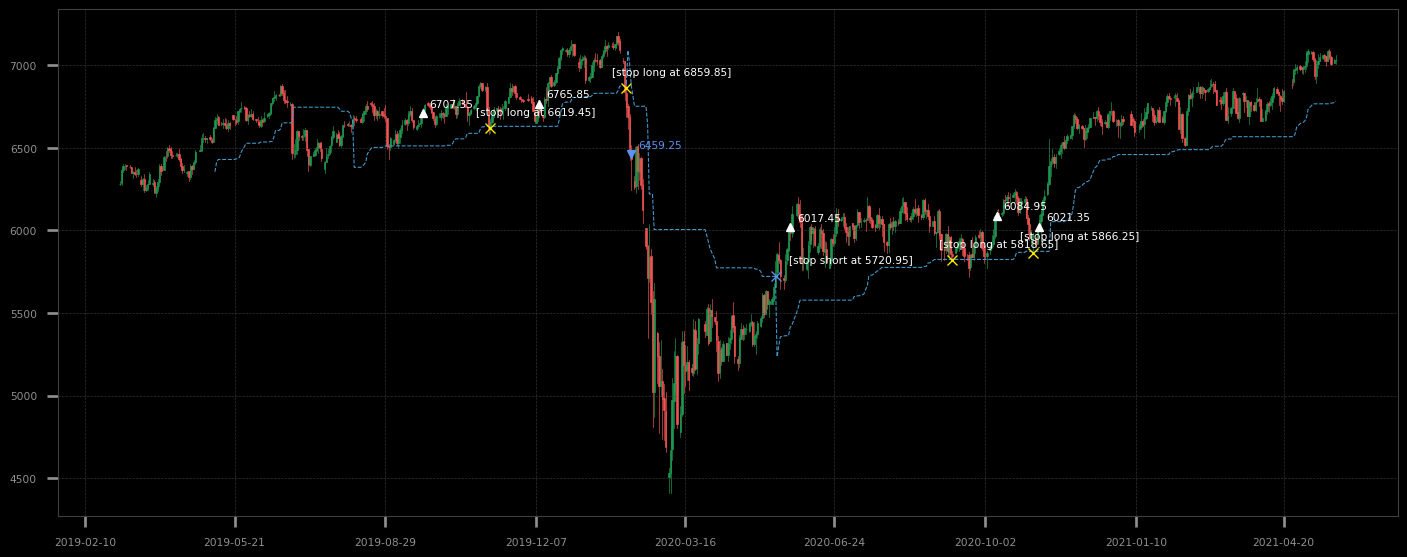

In [56]:
fig(18, 7)
rd = rad_indicator(md['AUS200'].ohlc('1d'), 22, 5, 'sma')
ohlc_plot(md['AUS200'].ohlc('1d'))
plt.plot(rd.rad.shift(1), '--')
plot_entries(r_aus.results[6].executions, font_size=8, ms=7)

<font color='green' size=2>Best model signals for SPXM</font>
<hr/>

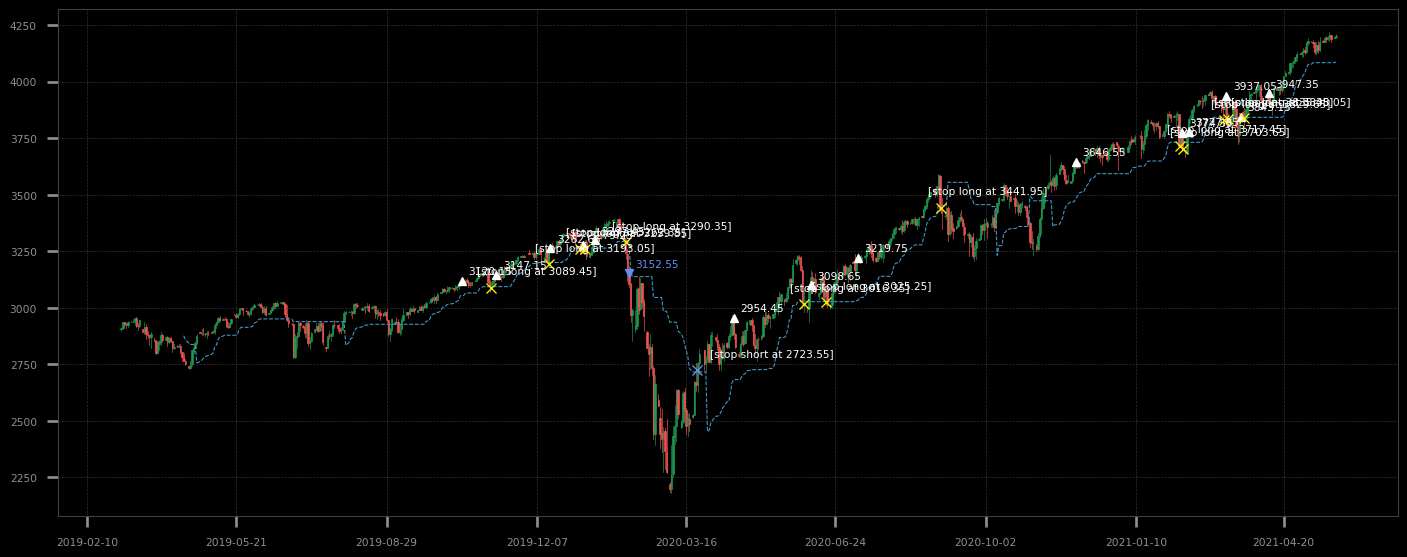

In [57]:
fig(18, 7)
rd = rad_indicator(md['SPXM'].ohlc('1d'), 12, 4)
ohlc_plot(md['SPXM'].ohlc('1d'))
plt.plot(rd.rad, '--')
plot_entries(r_spx.results[3].executions, font_size=8, ms=7)

<font color='green' size=2>Best model signals for XTI</font>
<hr/>

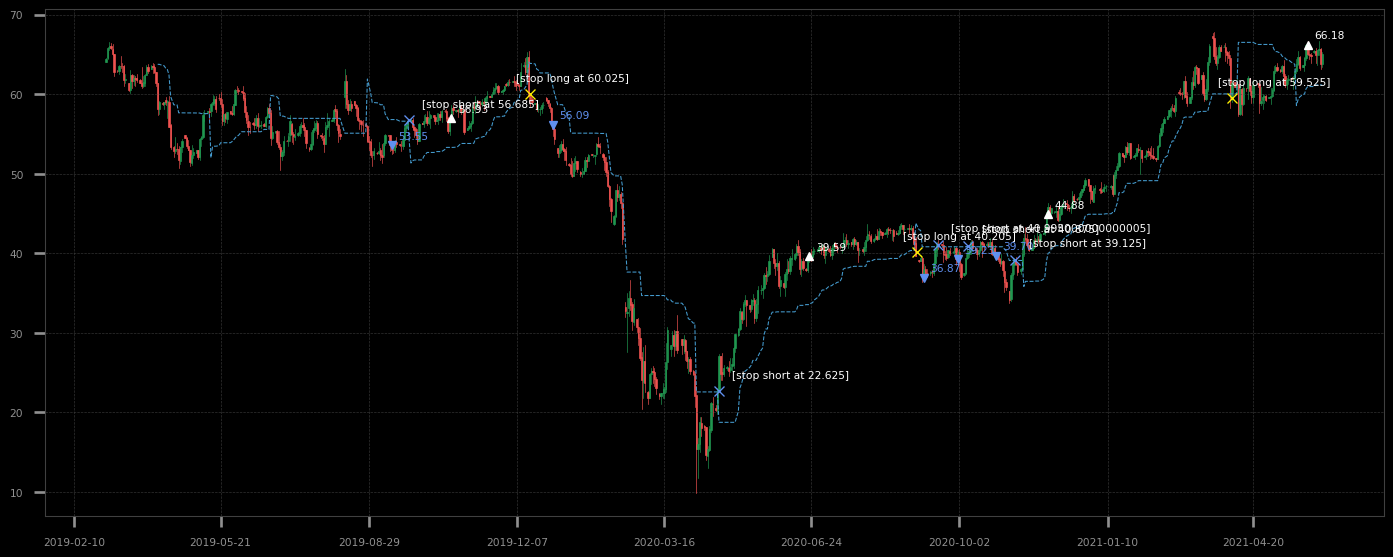

In [58]:
fig(18, 7)
rd = rad_indicator(md['XTIUSD'].ohlc('1d'), 22, 4)
ohlc_plot(md['XTIUSD'].ohlc('1d'))
plt.plot(rd.rad, '--')
plot_entries(r_xti.results[4].executions, font_size=8, ms=7)

<font color='orange' size=2>As we can see model (trailing RAD chandelier stop / no increasing positions) works correct and performs better during trend periods.</font>

There are some concerns:
1. Small number of entries
2. As CFD is OTC instrument, historical data for them provided with so named 'tick volumes' (not real traded amount but number of price changes during bar) so I suspect that volume filter may lead to wrong entries
3. It produces loses during flat periods of market (like period on chart below) 


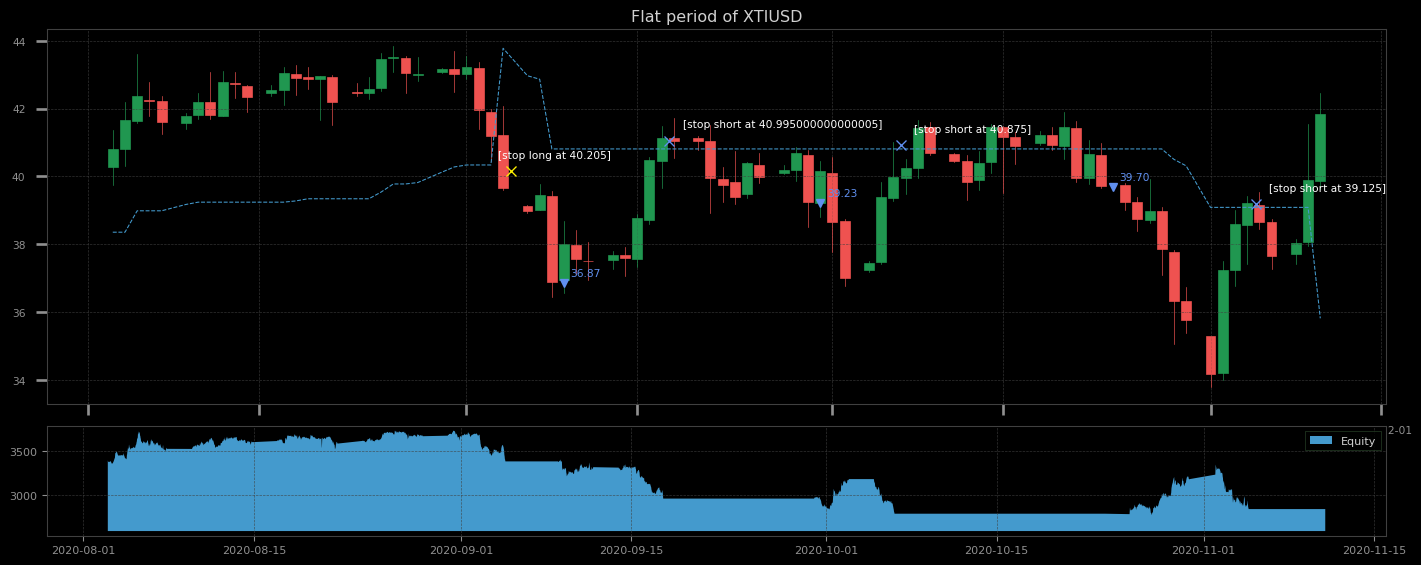

In [61]:
fig(18, 7)
_z = slice('2020-08-03', '2020-11-10')
rd = rad_indicator(md['XTIUSD'].ohlc('1d'), 22, 4)
sbp(41,1,r=3)
ohlc_plot(md['XTIUSD'].ohlc('1d')[_z])
plt.plot(rd.rad[_z], '--')
plot_entries(r_xti.results[4].executions[_z], font_size=8, ms=7); plt.title('Flat period of XTIUSD');

sbp(41,4)
eq = r_xti.results[4].equity()[_z]
plt.fill_between(eq.index, eq, 2600, label='Equity'); plt.legend();

<font color='green' size=2>Combined portfolio (AUS200 + SPXM + XTIUSD) on AMP futures data</font>
<hr/>


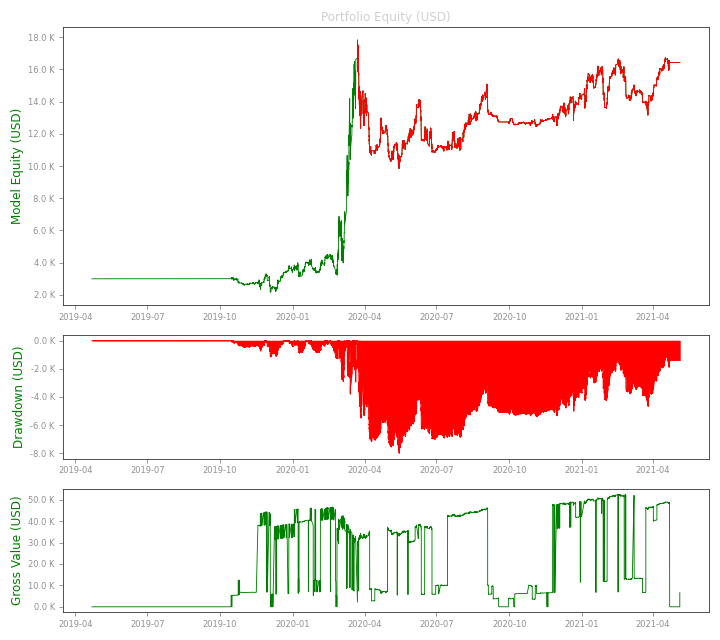

<Figure size 720x640 with 0 Axes>

In [131]:
tearsheet(scols(r_aus.results[6].portfolio, r_spx.results[3].portfolio, r_xti.results[4].portfolio), 3000)

<font color='orange' size=2>
    We can conclude that in general model is profitable especially during trending periods (especially during flash crashes).
    But we can also see that performance is moderate when market is not in strong trend motion.
    
</font>

# Testing on data from DukasCopy

Now we will use historical CFD data loaded from DukasCopy and compare them against data from AMP futures for same model.

Were we have longer history for SP500, Oil:

In [24]:
ls_symbols('dukas')

LIGHTUSD:	2013-01-01 00:44:00 - 2021-05-16 19:59:00
DIAUSD:	2017-05-11 09:30:00 - 2021-05-14 15:59:00
SPYUSD:	2017-02-16 10:27:00 - 2021-05-14 15:59:00
BRENTUSD:	2010-12-01 20:00:00 - 2021-05-14 16:59:00


In [62]:
md_d = load_data('dukas:SPYUSD', 'dukas:BRENTUSD', 'dukas:DIAUSD')

 <font color='green' size=2>CFD on SPY ETF </font>
 <hr/>

In [80]:
lbr_d = q.SingleInstrumentComposer(Lustre('1d', 14, 0.75, 150, 10)).fit(md_d.ticks())

In [ ]:
r_spy = q.simulation({
    'Basic / no RM (spy)': [lbr_d, q.FixedTrader(10, 0, 0)], 
    'Basic / RAD(daily, 12 x 3) (spy)': [lbr_d, RADChandelier(10, '1d', 12, 3)], 
    'Basic / RAD(daily, 22 x 3) (spy)': [lbr_d, RADChandelier(10, '1d', 22, 3)], 
    'Basic / RAD(daily, 12 x 4) (spy)': [lbr_d, RADChandelier(10, '1d', 12, 4)], 
    'Basic / RAD(daily, 22 x 4) (spy)': [lbr_d, RADChandelier(10, '1d', 22, 4)], 
    'Basic / RAD(daily, 12 x 5) (spy)': [lbr_d, RADChandelier(10, '1d', 12, 5)], 
    'Basic / RAD(daily, 22 x 5) (spy)': [lbr_d, RADChandelier(10, '1d', 22, 5)], 
}, md_d['SPYUSD'].ohlcs('1h'), 'stock', 'Lustre Optimal', spreads=0.02)

 0: Lustre Optimal/Basic / no RM (spy)               : Sharpe: 0.04 | Sortino: 0.06 | CAGR: -1.14 | DD: $1720.69 (51.13%) | Gain: $-203.89 | Execs: 15[OK]
 1: Lustre Optimal/Basic / RAD(daily, 12 x 3) (spy)  : Sharpe: -0.00 | Sortino: -0.00 | CAGR: -0.68 | DD: $723.71 (21.70%) | Gain: $-122.40 | Execs: 46[OK]
 2: Lustre Optimal/Basic / RAD(daily, 22 x 3) (spy)  : Sharpe: -0.28 | Sortino: -0.35 | CAGR: -2.04 | DD: $896.49 (26.73%) | Gain: $-355.94 | Execs: 44[OK]
 3: Lustre Optimal/Basic / RAD(daily, 12 x 4) (spy)  : Sharpe: 0.01 | Sortino: 0.02 | CAGR: -0.62 | DD: $988.35 (28.16%) | Gain: $-112.14 | Execs: 43[OK]
 4: Lustre Optimal/Basic / RAD(daily, 22 x 4) (spy)  : Sharpe: 0.06 | Sortino: 0.08 | CAGR: -0.08 | DD: $1033.53 (30.71%) | Gain: $-14.58 | Execs: 42[OK]
 5: Lustre Optimal/Basic / RAD(daily, 12 x 5) (spy)  : Sharpe: 0.49 | Sortino: 0.72 | CAGR: 5.27 | DD: $964.90 (24.20%) | Gain: $1111.73 | Execs: 27[OK]
 6: Lustre Optimal/Basic / RAD(daily, 22 x 5) (spy)  : Sharpe: 0.34 | So

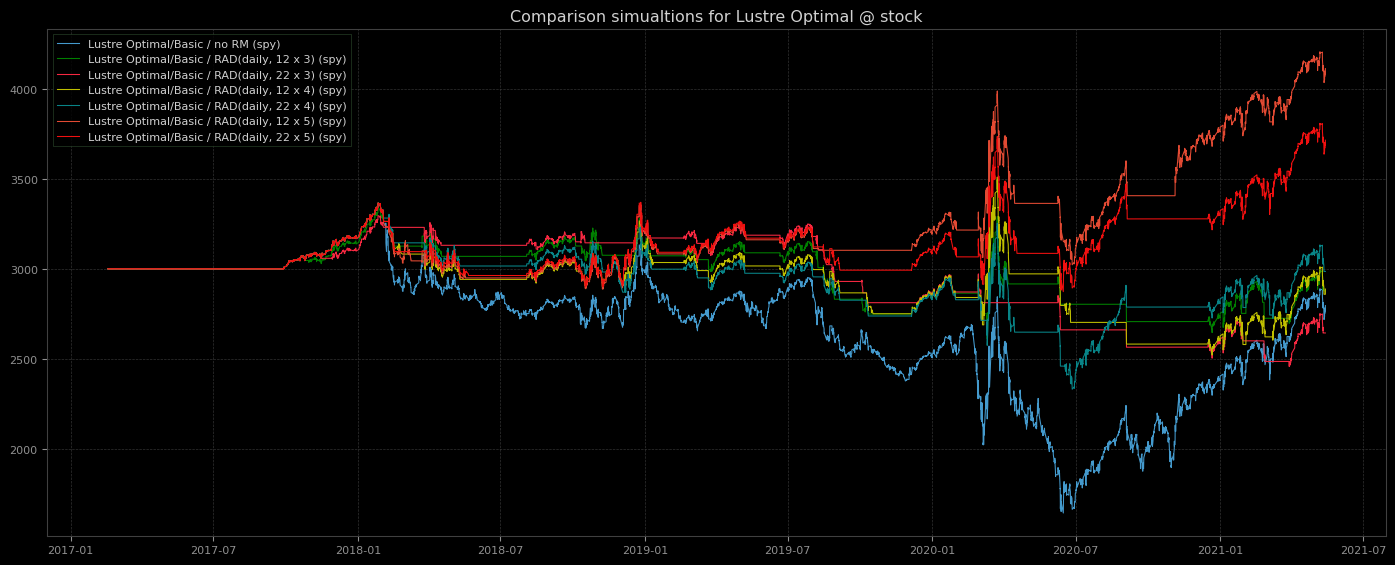

In [119]:
fig(18, 7)
res_r_spy = r_spy.report(3000)

<hr/>
We can see that applying RAD trailing stops improved strategy on SPY ETH CFD. 


In [118]:
res_r_spy.sort_values('sharpe', ascending=False)

,Name,sharpe,sortino,cagr,dd,dd_pct,gain,number_executions
5,"Lustre Optimal/Basic / RAD(daily, 12 x 5) (spy)",0.490079,0.722828,5.265608,964.900,24.198878,1111.725,27
6,"Lustre Optimal/Basic / RAD(daily, 22 x 5) (spy)",0.341922,0.500455,3.537772,861.850,23.073731,714.250,27
4,"Lustre Optimal/Basic / RAD(daily, 22 x 4) (spy)",0.059250,0.083321,-0.079305,1033.535,30.712895,-14.585,42
0,Lustre Optimal/Basic / no RM (spy),0.041000,0.057584,-1.139233,1720.690,51.132639,-203.890,15
3,"Lustre Optimal/Basic / RAD(daily, 12 x 4) (spy)",0.014740,0.021226,-0.618285,988.355,28.160589,-112.145,43
1,"Lustre Optimal/Basic / RAD(daily, 12 x 3) (spy)",-0.003021,-0.004413,-0.675850,723.710,21.697815,-122.405,46
2,"Lustre Optimal/Basic / RAD(daily, 22 x 3) (spy)",-0.279432,-0.347077,-2.035001,896.490,26.725395,-355.940,44


Best performer is:

 0: Lustre Optimal/Basic / RAD(daily, 12 x 5) (spy)  : Sharpe: 0.70 | Sortino: 1.11 | CAGR: 28.68 | DD: $9649.00 (74.95%) | Gain: $11117.25 | Execs: 27[OK]


,Name,sharpe,sortino,cagr,dd,dd_pct,gain,number_executions
0,"Lustre Optimal/Basic / RAD(daily, 12 x 5) (spy)",0.699454,1.114036,28.67605,9649.0,74.950966,11117.25,27


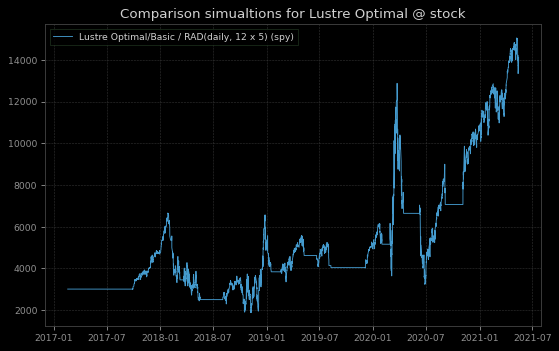

In [110]:
r_spy[5].report(3000)

 <font color='green' size=2>CFD on BRENT Oil </font>
 <hr/>

Running model on Brent Oil CMD (from DukasCopy) gives us following resuls:

In [ ]:
r_brent = q.simulation({
    'Basic / no RM (spy)': [lbr_d, q.FixedTrader(10, 0, 0)], 
    'Basic / RAD(daily, 12 x 3) (spy)': [lbr_d, RADChandelier(10, '1d', 12, 3)], 
    'Basic / RAD(daily, 22 x 3) (spy)': [lbr_d, RADChandelier(10, '1d', 22, 3)], 
    'Basic / RAD(daily, 12 x 4) (spy)': [lbr_d, RADChandelier(10, '1d', 12, 4)], 
    'Basic / RAD(daily, 22 x 4) (spy)': [lbr_d, RADChandelier(10, '1d', 22, 4)], 
    'Basic / RAD(daily, 12 x 5) (spy)': [lbr_d, RADChandelier(10, '1d', 12, 5)], 
    'Basic / RAD(daily, 22 x 5) (spy)': [lbr_d, RADChandelier(10, '1d', 22, 5)], 
}, md_d['BRENTUSD'].ohlcs('1h'), 'stock', 'Lustre Optimal', spreads=0.05)

 0: Lustre Optimal/Basic / no RM (spy)               : Sharpe: 0.03 | Sortino: 0.04 | CAGR: -0.01 | DD: $704.66 (23.14%) | Gain: $-5.24 | Execs: 59[OK]
 1: Lustre Optimal/Basic / RAD(daily, 12 x 3) (spy)  : Sharpe: 0.40 | Sortino: 0.60 | CAGR: 1.41 | DD: $408.67 (13.42%) | Gain: $708.38 | Execs: 139[OK]
 2: Lustre Optimal/Basic / RAD(daily, 22 x 3) (spy)  : Sharpe: 0.39 | Sortino: 0.58 | CAGR: 1.40 | DD: $390.47 (12.82%) | Gain: $700.25 | Execs: 149[OK]
 3: Lustre Optimal/Basic / RAD(daily, 12 x 4) (spy)  : Sharpe: 0.12 | Sortino: 0.17 | CAGR: 0.41 | DD: $559.72 (18.29%) | Gain: $192.59 | Execs: 119[OK]
 4: Lustre Optimal/Basic / RAD(daily, 22 x 4) (spy)  : Sharpe: 0.28 | Sortino: 0.40 | CAGR: 1.07 | DD: $526.31 (17.51%) | Gain: $524.40 | Execs: 105[OK]
 5: Lustre Optimal/Basic / RAD(daily, 12 x 5) (spy)  : Sharpe: 0.46 | Sortino: 0.69 | CAGR: 1.57 | DD: $345.55 (11.25%) | Gain: $797.16 | Execs: 77[OK]
 6: Lustre Optimal/Basic / RAD(daily, 22 x 5) (spy)  : Sharpe: 0.08 | Sortino: 0.12 

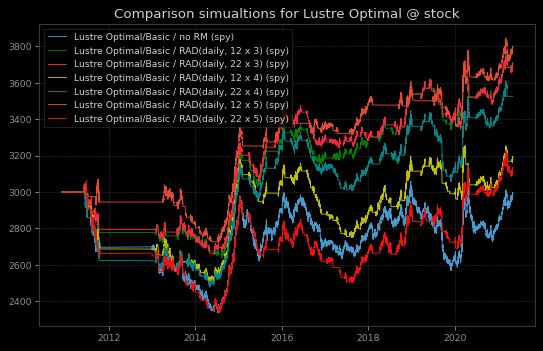

In [111]:
r_brent_rep = r_brent.report(3000)

In [112]:
r_brent_rep.sort_values('sharpe', ascending=False)

,Name,sharpe,sortino,cagr,dd,dd_pct,gain,number_executions
5,"Lustre Optimal/Basic / RAD(daily, 12 x 5) (spy)",0.458846,0.687021,1.571205,345.550,11.249215,797.165,77
1,"Lustre Optimal/Basic / RAD(daily, 12 x 3) (spy)",0.400435,0.603702,1.412349,408.665,13.418254,708.385,139
2,"Lustre Optimal/Basic / RAD(daily, 22 x 3) (spy)",0.386846,0.580359,1.397616,390.470,12.820833,700.250,149
4,"Lustre Optimal/Basic / RAD(daily, 22 x 4) (spy)",0.275088,0.401225,1.071509,526.310,17.512145,524.400,105
3,"Lustre Optimal/Basic / RAD(daily, 12 x 4) (spy)",0.119579,0.172277,0.412492,559.715,18.286977,192.590,119
6,"Lustre Optimal/Basic / RAD(daily, 22 x 5) (spy)",0.084181,0.119319,0.287624,721.730,23.580322,133.105,101
0,Lustre Optimal/Basic / no RM (spy),0.026360,0.037640,-0.011565,704.660,23.137060,-5.240,59


Best performer is:

 0: Lustre Optimal/Basic / RAD(daily, 12 x 5) (spy)  : Sharpe: 0.46 | Sortino: 0.69 | CAGR: 1.57 | DD: $345.55 (11.25%) | Gain: $797.16 | Execs: 77[OK]


,Name,sharpe,sortino,cagr,dd,dd_pct,gain,number_executions
0,"Lustre Optimal/Basic / RAD(daily, 12 x 5) (spy)",0.458846,0.687021,1.571205,345.55,11.249215,797.165,77


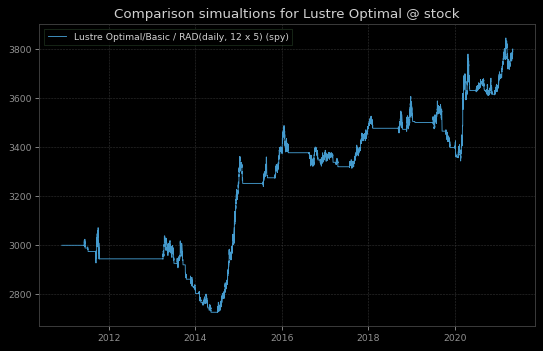

In [113]:
r_brent[5].report(3000)

<font color='green' size=2>Combined portfolio (SPY + BRENT) on DukasCopy</font>
<hr/>


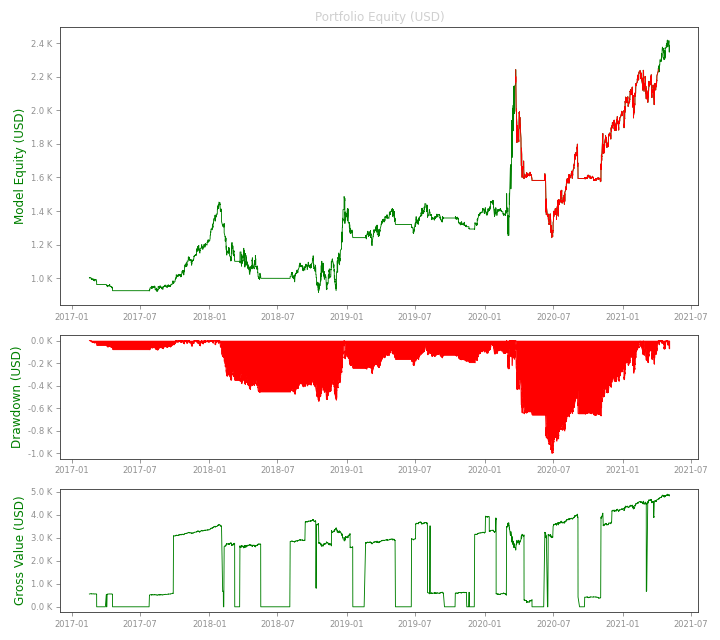

<Figure size 720x640 with 0 Axes>

In [129]:
tearsheet(scols(r_brent[5].results[0].portfolio, r_spy[5].results[0].portfolio).dropna(), 1000)

<font color='orange' size=2>
    On DukasCopy data we see similar picture - model catches flash market movements but also performs poor diring flat market.
</font>